In [1]:
import os
import time
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.fftpack import fft
from IPython.display import display

import pywt
import scipy.stats

import datetime as dt
from collections import defaultdict, Counter

from sklearn.ensemble import GradientBoostingClassifier

In [2]:
import os
import pandas as pd
import numpy as np
import librosa
from tqdm import tqdm

# Define function for feature extraction using MFCC and mean
def features_extractor(file_path):
    # Load audio file
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    
    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
    
    # Take the mean of MFCC coefficients along the time axis
    mfcc_mean = np.mean(mfccs, axis=1)
    
    return mfcc_mean.tolist()  # Convert to list for easier appending to features list

# Define path and mappings
audio_dataset_path = r"D:\SDP\Dataset"
metadata = pd.read_csv('HVD_Data.csv')

label_to_folder = {
    "AS": "AS_New",
    "MR": "MR_New",
    "MS": "MS_New",
    "MVP": "MVP_New",
    "N": "N_New"
}

# Iterate through metadata and extract features
extracted_features = []
list_labels = []  # List to store labels
for index_num, row in tqdm(metadata.iterrows()):
    file_label = row["Label"]  # Change "Label" to the correct column name
    folder_name = label_to_folder.get(file_label)
    if folder_name:
        file_name = os.path.join(audio_dataset_path, folder_name, row["Name"])
        features = features_extractor(file_name) 
        extracted_features.append(features)
        list_labels.append(file_label)

# Create DataFrame from extracted features and labels
df = pd.DataFrame(extracted_features)
df['label'] = list_labels

# Split data into train and test sets (You can use train_test_split from sklearn)
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['label'])  # Adjust test_size as needed

# Separate features and labels for train and test sets
X_train, Y_train = df_train.drop('label', axis=1), df_train['label']
X_test, Y_test = df_test.drop('label', axis=1), df_test['label']


1000it [00:50, 19.67it/s]


In [3]:
X_train.shape

(800, 13)

In [4]:
Y_train.shape

(800,)

### Gradinet Booster

In [5]:
cls = GradientBoostingClassifier(n_estimators=10000)
cls.fit(X_train, Y_train)
train_score = cls.score(X_train, Y_train)
test_score = cls.score(X_test, Y_test)
print("The Train Score is {}".format(train_score))
print("The Test Score is {}".format(test_score))

The Train Score is 1.0
The Test Score is 0.965


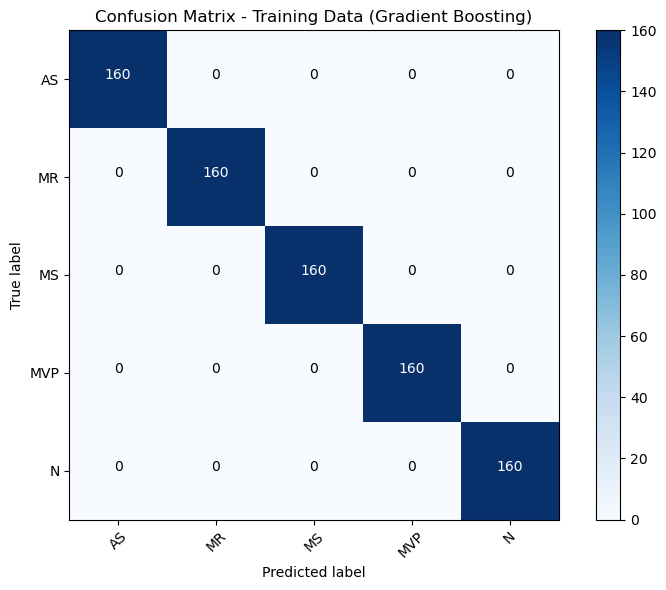

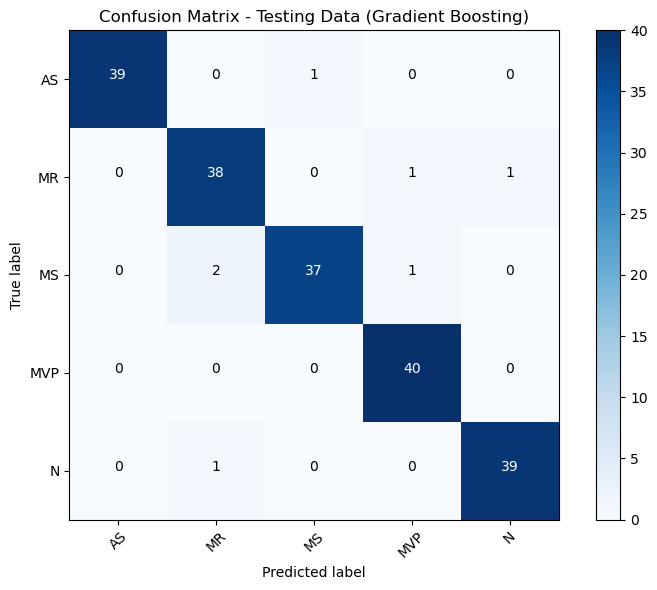

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Predictions
y_train_pred_gb = cls.predict(X_train)
y_test_pred_gb = cls.predict(X_test)

# Calculate confusion matrix for training data
conf_matrix_train_gb = confusion_matrix(Y_train, y_train_pred_gb)

# Calculate confusion matrix for testing data
conf_matrix_test_gb = confusion_matrix(Y_test, y_test_pred_gb)

# Plot confusion matrix for training data
plot_confusion_matrix(conf_matrix_train_gb, title="Confusion Matrix - Training Data (Gradient Boosting)")

# Plot confusion matrix for testing data
plot_confusion_matrix(conf_matrix_test_gb, title="Confusion Matrix - Testing Data (Gradient Boosting)")


### ANN

In [4]:
# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models

# Create a simple ANN model
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(13,)),  # Specify input shape
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')  # Assuming 5 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

# Train the model
history = model.fit(X_train, Y_train_encoded,batch_size=32, epochs=100, validation_data=(X_test, Y_test_encoded))

# Evaluate the model
train_score_ann = model.evaluate(X_train, Y_train_encoded, verbose=0)
test_score_ann = model.evaluate(X_test, Y_test_encoded, verbose=0)

# Print scores
print("ANN Train Score:", train_score_ann[1])
print("ANN Test Score:", test_score_ann[1])



C:\Users\G phanindra\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.3043 - loss: 13.2102 - val_accuracy: 0.4650 - val_loss: 2.7455
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5898 - loss: 1.6361 - val_accuracy: 0.5800 - val_loss: 1.0561
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6715 - loss: 0.9177 - val_accuracy: 0.6400 - val_loss: 1.0106
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6904 - loss: 0.8376 - val_accuracy: 0.6250 - val_loss: 0.9669
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7103 - loss: 0.7707 - val_accuracy: 0.6700 - val_loss: 0.8737
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6930 - loss: 0.8059 - val_accuracy: 0.5950 - val_loss: 1.0148
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7136 - loss: 0.7904 - val_accuracy: 0.6250 - val_loss: 0.8993
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6232 - loss: 0.8870 - val_accuracy: 0.655

In [22]:
# Print scores
print("ANN Train Score:", train_score_ann[1])
print("ANN Test Score:", test_score_ann[1])

ANN Train Score: 0.9837499856948853
ANN Test Score: 0.9649999737739563


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


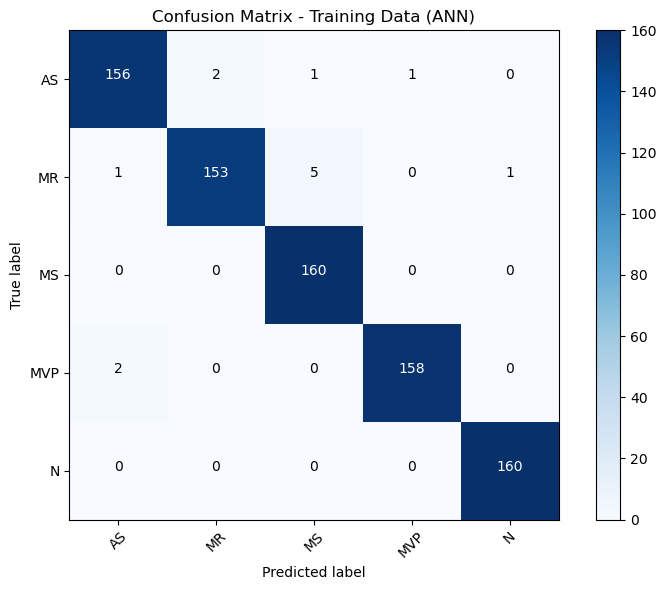

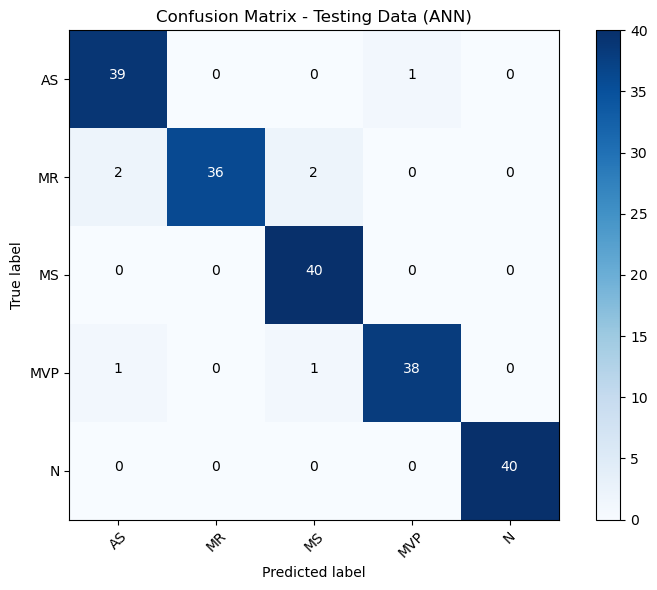

In [23]:
# Predictions
y_train_pred_ann_probs = model.predict(X_train)
y_train_pred_ann = np.argmax(y_train_pred_ann_probs, axis=1)

y_test_pred_ann_probs = model.predict(X_test)
y_test_pred_ann = np.argmax(y_test_pred_ann_probs, axis=1)

# Calculate confusion matrix for training data
conf_matrix_train_ann = confusion_matrix(Y_train_encoded, y_train_pred_ann)

# Calculate confusion matrix for testing data
conf_matrix_test_ann = confusion_matrix(Y_test_encoded, y_test_pred_ann)

# Plot confusion matrix for training data
plot_confusion_matrix(conf_matrix_train_ann, title="Confusion Matrix - Training Data (ANN)")

# Plot confusion matrix for testing data
plot_confusion_matrix(conf_matrix_test_ann, title="Confusion Matrix - Testing Data (ANN)")


### KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors (n_neighbors) as needed

# Train the model
knn_model.fit(X_train, Y_train_encoded)  # Use integer-encoded labels directly

# Predictions
y_train_pred_knn = knn_model.predict(X_train)
y_test_pred_knn = knn_model.predict(X_test)

# Calculate accuracy
train_accuracy_knn = accuracy_score(Y_train_encoded, y_train_pred_knn)
test_accuracy_knn = accuracy_score(Y_test_encoded, y_test_pred_knn)

print("Training Accuracy (KNN):", train_accuracy_knn)
print("Testing Accuracy (KNN):", test_accuracy_knn)


Training Accuracy (KNN): 0.97625
Testing Accuracy (KNN): 0.945


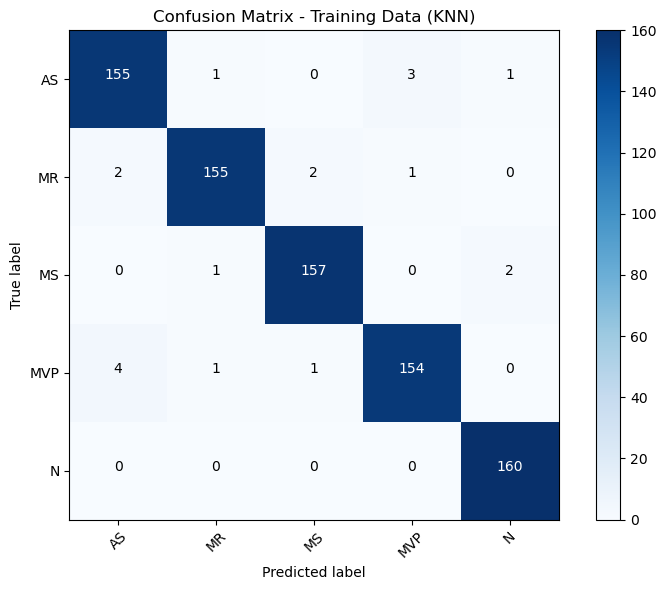

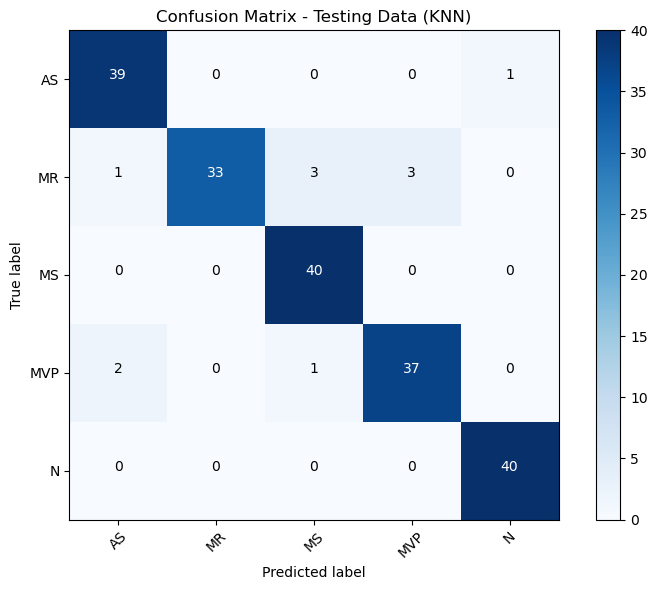

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate confusion matrix for training data
conf_matrix_train_knn = confusion_matrix(Y_train_encoded, y_train_pred_knn)

# Calculate confusion matrix for testing data
conf_matrix_test_knn = confusion_matrix(Y_test_encoded, y_test_pred_knn)

# Plot confusion matrix for training data
plot_confusion_matrix(conf_matrix_train_knn, title="Confusion Matrix - Training Data (KNN)")

# Plot confusion matrix for testing data
plot_confusion_matrix(conf_matrix_test_knn, title="Confusion Matrix - Testing Data (KNN)")


### LSTM

In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import accuracy_score

# Assuming you have already defined X_train, X_test, Y_train_encoded, and Y_test_encoded

# Reshape X_train and X_test
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define LSTM model
lstm_model = Sequential([
    LSTM(110, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(5, activation='softmax')
])

# Compile the model
lstm_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Train the model
lstm_model.fit(X_train_reshaped, Y_train_encoded, epochs=100, validation_data=(X_test_reshaped, Y_test_encoded))

# Predictions
y_train_pred_lstm_probs = lstm_model.predict(X_train_reshaped)
y_train_pred_lstm = np.argmax(y_train_pred_lstm_probs, axis=1)

y_test_pred_lstm_probs = lstm_model.predict(X_test_reshaped)
y_test_pred_lstm = np.argmax(y_test_pred_lstm_probs, axis=1)

# Calculate accuracy
train_accuracy_lstm = accuracy_score(Y_train_encoded, y_train_pred_lstm)
test_accuracy_lstm = accuracy_score(Y_test_encoded, y_test_pred_lstm)

print("Training Accuracy (LSTM):", train_accuracy_lstm)
print("Testing Accuracy (LSTM):", test_accuracy_lstm)


C:\Users\G phanindra\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.4002 - loss: 1.3980 - val_accuracy: 0.4900 - val_loss: 1.0791
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5788 - loss: 0.9841 - val_accuracy: 0.5200 - val_loss: 0.9931
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6425 - loss: 0.8643 - val_accuracy: 0.6350 - val_loss: 0.8600
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6780 - loss: 0.7532 - val_accuracy: 0.6850 - val_loss: 0.7305
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7289 - loss: 0.6749 - val_accuracy: 0.7200 - val_loss: 0.6326
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8026 - loss: 0.5440 - val_accuracy: 0.8250 - val_loss: 0.5399
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8364 - loss: 0.4987 - val_accuracy: 0.8350 - val_loss: 0.4962
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8597 - loss: 0.4410 - val_accuracy: 0.

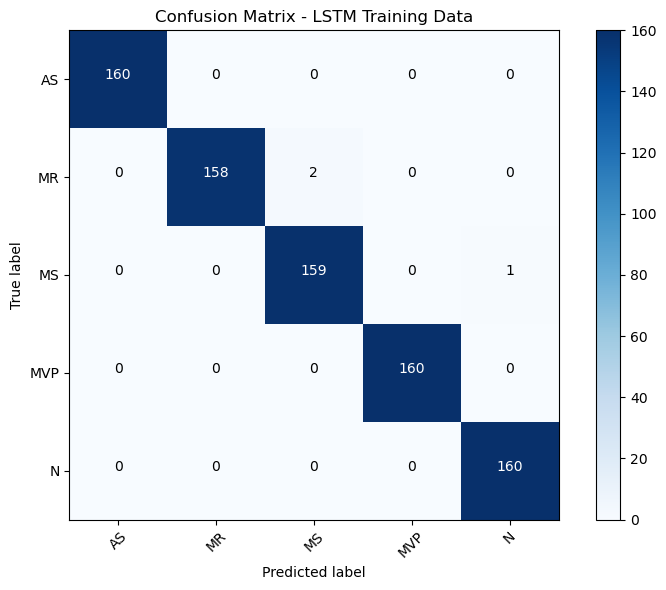

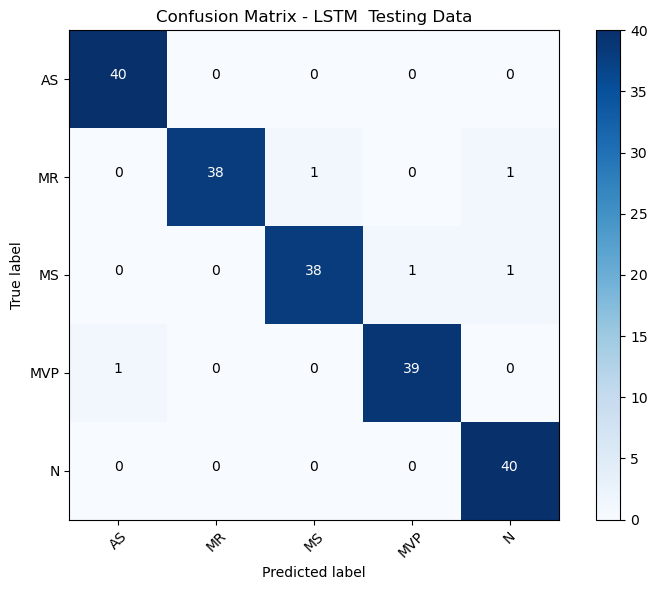

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate confusion matrix for training data
conf_matrix_train = confusion_matrix(Y_train_encoded, y_train_pred_lstm)

# Calculate confusion matrix for testing data
conf_matrix_test = confusion_matrix(Y_test_encoded, y_test_pred_lstm)

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_to_folder))
    plt.xticks(tick_marks, label_to_folder.keys(), rotation=45)
    plt.yticks(tick_marks, label_to_folder.keys())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix)):
            plt.text(j, i, format(conf_matrix[i, j]), horizontalalignment="center", color="white" if conf_matrix[i, j] > np.max(conf_matrix)/2 else "black")
    plt.tight_layout()
    plt.show()

# Plot confusion matrix for training data
plot_confusion_matrix(conf_matrix_train, title="Confusion Matrix - LSTM Training Data")

# Plot confusion matrix for testing data
plot_confusion_matrix(conf_matrix_test, title="Confusion Matrix - LSTM  Testing Data")


In [13]:
print(X_train.shape)

(800, 13)


In [ ]:
import tkinter as tk
from tkinter import filedialog
from tensorflow.keras.models import load_model

def select_file_and_predict():
    # Create file dialog
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    file_path = filedialog.askopenfilename(filetypes=[("WAV files", "*.wav")])
    if file_path:
        print("Selected file:", file_path)

        # Extract features
        features = features_extractor(file_path)
        features = np.array(features).reshape(1, -1, 1)  # Reshape for LSTM model

        # Load the trained model (make sure the model is saved in the same directory or provide the correct path)
        lstm_model = load_model('lstm_model.h5')

        # Predict
        prediction_probs = lstm_model.predict(features)
        prediction = np.argmax(prediction_probs, axis=1)

        # Define the labels based on your classification
        labels = ["AS", "MR", "MS", "MVP", "N"]
        predicted_label = labels[prediction[0]]
        print("Predicted label:", predicted_label)

if __name__ == "__main__":
    select_file_and_predict()